In [26]:
import random
import re
import requests
import pandas as pd
from datetime import datetime, timedelta
from datetime import datetime
import matplotlib.pyplot as plt
from ipywidgets import widgets
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.compose import ColumnTransformer


#Data I'm adding:
years = pd.Series(['2005','2006', '2007','2008', '2009', '2010','2011','2012', '2013','2014', '2015', '2016', 
         '2017', '2018','2019', '2020', '2021'])
years = [int(i) for i in years]
homeless_pop = pd.Series(['6026','6157', '5757','6044', '6228', '6539','6546','6954', '6865','7748', '7298', '8350', 
         '7473', '6904','6521', '6380', '5111'])
homeless_pop = [int(i) for i in homeless_pop]
dc_pop = pd.Series(['582049','585171', '588292','588363', '588433', '605125','619624','633427', '646669','658893', 
                    '672228', '681170', '693972', '702455','705749', '689545', '690345'])
dc_pop = [int(i) for i in dc_pop]
df_added_data = pd.DataFrame({'year': years, 'homeless_pop': homeless_pop, 'dc_pop' : dc_pop})


hypo_season = pd.Series(['1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1'])
hypo_season = [int(i) for i in hypo_season]
month = pd.Series(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
month = [int(i) for i in month]
df_added_hypo = pd.DataFrame({'month': month, 'hypo_season': hypo_season})


In [5]:
#I'm particularly interested in what the medically vulnerable housing looks like (DHS) and
#in the mostly-family COH-Triumph 2019 spike that ends up in the women's shelter (to be removed)

df_latest = pd.read_csv("InShelterPerDay_Gender_Shelter_10-06-2021.csv")
df_latest['date'] = pd.to_datetime(df_latest['date'])
df_latest['DHS_Pan'] = df_latest['Male'] + df_latest['Female']
df_latest['COH_Triumph'] = df_latest['Male'] + df_latest['Female']

mask = (df_latest['name'] == 'DHS - Pandemic Emergency Program - ES - DHS Direct')
df_pan = df_latest[['date', 'DHS_Pan', 'name']].loc[mask]
df_pan = df_pan.dropna()
#df_pan.head(-10)

mask = (df_latest['name'] == 'COH - The Triumph - DHS STFH - ES FAM - DHS Direct')
df_coh = df_latest[['date', 'COH_Triumph', 'name']].loc[mask]
df_coh = df_coh.dropna()
df_coh.head(-10)



,date,COH_Triumph,name
20,2005-01-01,0.0,COH - The Triumph - DHS STFH - ES FAM - DHS Di...
77,2005-01-02,0.0,COH - The Triumph - DHS STFH - ES FAM - DHS Di...
134,2005-01-03,0.0,COH - The Triumph - DHS STFH - ES FAM - DHS Di...
191,2005-01-04,0.0,COH - The Triumph - DHS STFH - ES FAM - DHS Di...
248,2005-01-05,0.0,COH - The Triumph - DHS STFH - ES FAM - DHS Di...
...,...,...,...
348176,2021-09-22,2.0,COH - The Triumph - DHS STFH - ES FAM - DHS Di...
348233,2021-09-23,2.0,COH - The Triumph - DHS STFH - ES FAM - DHS Di...
348290,2021-09-24,2.0,COH - The Triumph - DHS STFH - ES FAM - DHS Di...
348347,2021-09-25,2.0,COH - The Triumph - DHS STFH - ES FAM - DHS Di...


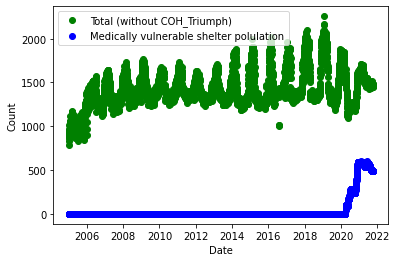

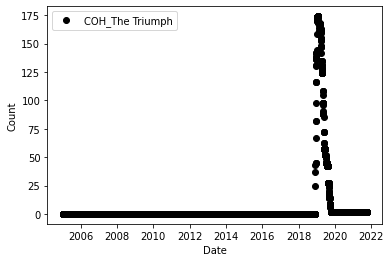

In [6]:
#Now to merge in data_added and do some clean up

#New gendered data from Rich on 10/6/2021: InShelterPerDayGender-10-16-2021.csv with problematic shelter CCNV removed
df_gender = pd.read_csv("InShelterPerDayGender-10-16-2021.csv")
df_gender['date'] = pd.to_datetime(df_gender['date']) 
df_gender['day_of_year'] = df_gender['date'].apply(lambda x: int(x.strftime('%j')))
df_gender['Total'] = df_gender['Male'] + df_gender['Female']
df_gender = df_gender.merge(df_added_data, how='left', left_on='year', right_on='year') #'how = left'
#df_gender = df.merge(df_added_hypo, how='left', left_on='month', right_on='month') #'how = left'
df_gender["PrecipIn"] = df_gender["PrecipIn"].fillna(0.0) #better to set unknowns to 0 than throw away data (small correlationto prediction)
df_gender["SnowIn"] = df_gender["SnowIn"].fillna(0.0) #better to set unknowns to 0 than throw away data (small correlationto prediction)
df_gender['dayWeek_alt'] = df_gender['dayWeek'].apply(lambda x: 10.0 -(x - 4.0)*(x - 4.0) ) #this is designed to capture max mid-week shelter usage
#need to fill in for missing MinTempF values on April 1, 2021 and beyond
df_gender.loc[df_gender.date >= datetime(2021, 4, 1), "MinTempF"] = "48.0"
df_gender.loc[df_gender.date >= datetime(2021, 5, 1), "MinTempF"] = "58.0"
df_gender.loc[df_gender.date >= datetime(2021, 6, 1), "MinTempF"] = "67.0"
df_gender.loc[df_gender.date >= datetime(2021, 7, 1), "MinTempF"] = "72.0"
df_gender.loc[df_gender.date >= datetime(2021, 8, 1), "MinTempF"] = "68.0"
df_gender.loc[df_gender.date >= datetime(2021, 9, 1), "MinTempF"] = "63.0"
df_gender.loc[df_gender.date >= datetime(2021, 10, 1), "MinTempF"] = "52.0"
df_gender["MinTempF"] = pd.to_numeric(df_gender["MinTempF"])

df_gender.loc[df_gender.date >= datetime(2021, 4, 1), "MaxTempF"] = "60.0"
df_gender["MaxTempF"] = pd.to_numeric(df_gender["MaxTempF"])

df_gender.loc[df_gender.date >= datetime(2021, 4, 1), "SnowIn"] = "0.0"
df_gender["SnowIn"] = pd.to_numeric(df_gender["SnowIn"])

df_gender.loc[df_gender.date >= datetime(2021, 4, 1), "PrecipIn"] = "0.0"
df_gender["PrecipIn"] = pd.to_numeric(df_gender["PrecipIn"])

df_gender.loc[df_gender.date >= datetime(2021, 4, 1), "FreezingAtEntry"] = "0.0"
df_gender["FreezingAtEntry"] = pd.to_numeric(df_gender["FreezingAtEntry"])

df_gender['MonthYear'] = df_gender['month'] + df_gender['year']/10000
df_gender['MetroBus'] = df_gender['SnowIn']
df_gender.loc[df_gender.date >= datetime(2000, 1, 1), "MetroBus"] = "0.46" #in millions of daily rides (mid-year ave.)
df_gender.loc[df_gender.date >= datetime(2015, 1, 1), "MetroBus"] = "0.44"
df_gender.loc[df_gender.date >= datetime(2016, 1, 1), "MetroBus"] = "0.41"
df_gender.loc[df_gender.date >= datetime(2017, 1, 1), "MetroBus"] = "0.37"
df_gender.loc[df_gender.date >= datetime(2018, 1, 1), "MetroBus"] = "0.36"
df_gender.loc[df_gender.date >= datetime(2019, 1, 1), "MetroBus"] = "0.35"
df_gender.loc[df_gender.date >= datetime(2020, 1, 1), "MetroBus"] = "0.35"
df_gender.loc[df_gender.date >= datetime(2020, 3, 1), "MetroBus"] = "0.18"
df_gender.loc[df_gender.date >= datetime(2020, 4, 1), "MetroBus"] = "0.0"
df_gender.loc[df_gender.date >= datetime(2020, 5, 1), "MetroBus"] = "0.02"
df_gender.loc[df_gender.date >= datetime(2020, 6, 1), "MetroBus"] = "0.02"
df_gender.loc[df_gender.date >= datetime(2020, 7, 1), "MetroBus"] = "0.03"
df_gender.loc[df_gender.date >= datetime(2020, 8, 1), "MetroBus"] = "0.03"
df_gender.loc[df_gender.date >= datetime(2020, 9, 1), "MetroBus"] = "0.04"
df_gender.loc[df_gender.date >= datetime(2020, 10, 1), "MetroBus"] = "0.04"
df_gender.loc[df_gender.date >= datetime(2020, 11, 1), "MetroBus"] = "0.04"
df_gender.loc[df_gender.date >= datetime(2020, 12, 1), "MetroBus"] = "0.04"
df_gender.loc[df_gender.date >= datetime(2021, 1, 1), "MetroBus"] = "0.11"
df_gender.loc[df_gender.date >= datetime(2021, 2, 1), "MetroBus"] = "0.10"
df_gender.loc[df_gender.date >= datetime(2021, 3, 1), "MetroBus"] = "0.12"
df_gender.loc[df_gender.date >= datetime(2021, 4, 1), "MetroBus"] = "0.12"
df_gender.loc[df_gender.date >= datetime(2021, 5, 1), "MetroBus"] = "0.13"
df_gender.loc[df_gender.date >= datetime(2021, 6, 1), "MetroBus"] = "0.14"
df_gender.loc[df_gender.date >= datetime(2021, 7, 1), "MetroBus"] = "0.14"
df_gender.loc[df_gender.date >= datetime(2021, 8, 1), "MetroBus"] = "0.15"
df_gender.loc[df_gender.date >= datetime(2021, 9, 1), "MetroBus"] = "0.12"
df_gender.loc[df_gender.date >= datetime(2021, 10, 1), "MetroBus"] = "0.23"
df_gender["MetroBus"] = pd.to_numeric(df_gender["MetroBus"])

df_gender.loc[df_gender.date >= datetime(2004, 6, 1), "homeless_pop"] = "6026"
df_gender.loc[df_gender.date >= datetime(2005, 6, 1), "homeless_pop"] = "6157"
df_gender.loc[df_gender.date >= datetime(2006, 6, 1), "homeless_pop"] = "5757"
df_gender.loc[df_gender.date >= datetime(2007, 6, 1), "homeless_pop"] = "6044"
df_gender.loc[df_gender.date >= datetime(2008, 6, 1), "homeless_pop"] = "6228"
df_gender.loc[df_gender.date >= datetime(2009, 6, 1), "homeless_pop"] = "6539"
df_gender.loc[df_gender.date >= datetime(2010, 6, 1), "homeless_pop"] = "6546"
df_gender.loc[df_gender.date >= datetime(2011, 6, 1), "homeless_pop"] = "6954"
df_gender.loc[df_gender.date >= datetime(2012, 6, 1), "homeless_pop"] = "6865"
df_gender.loc[df_gender.date >= datetime(2013, 6, 1), "homeless_pop"] = "7748"
df_gender.loc[df_gender.date >= datetime(2014, 6, 1), "homeless_pop"] = "7298"
df_gender.loc[df_gender.date >= datetime(2015, 6, 1), "homeless_pop"] = "8350"
df_gender.loc[df_gender.date >= datetime(2016, 6, 1), "homeless_pop"] = "7473"
df_gender.loc[df_gender.date >= datetime(2017, 6, 1), "homeless_pop"] = "6904"
df_gender.loc[df_gender.date >= datetime(2018, 6, 1), "homeless_pop"] = "6521"
df_gender.loc[df_gender.date >= datetime(2019, 6, 1), "homeless_pop"] = "6380"
df_gender.loc[df_gender.date >= datetime(2020, 6, 1), "homeless_pop"] = "5111"
df_gender["homeless_pop"] = pd.to_numeric(df_gender["homeless_pop"])

df_gender.loc[df_gender.date >= datetime(2004, 6, 1), "dc_pop"] = "582049"
df_gender.loc[df_gender.date >= datetime(2005, 6, 1), "dc_pop"] = "585171"
df_gender.loc[df_gender.date >= datetime(2006, 6, 1), "dc_pop"] = "588292"
df_gender.loc[df_gender.date >= datetime(2007, 6, 1), "dc_pop"] = "588363"
df_gender.loc[df_gender.date >= datetime(2008, 6, 1), "dc_pop"] = "588433"
df_gender.loc[df_gender.date >= datetime(2009, 6, 1), "dc_pop"] = "605125"
df_gender.loc[df_gender.date >= datetime(2010, 6, 1), "dc_pop"] = "619624"
df_gender.loc[df_gender.date >= datetime(2011, 6, 1), "dc_pop"] = "633427"
df_gender.loc[df_gender.date >= datetime(2012, 6, 1), "dc_pop"] = "646669"
df_gender.loc[df_gender.date >= datetime(2013, 6, 1), "dc_pop"] = "658893"
df_gender.loc[df_gender.date >= datetime(2014, 6, 1), "dc_pop"] = "672228"
df_gender.loc[df_gender.date >= datetime(2015, 6, 1), "dc_pop"] = "681170"
df_gender.loc[df_gender.date >= datetime(2016, 6, 1), "dc_pop"] = "693972"
df_gender.loc[df_gender.date >= datetime(2017, 6, 1), "dc_pop"] = "702455"
df_gender.loc[df_gender.date >= datetime(2018, 6, 1), "dc_pop"] = "705749"
df_gender.loc[df_gender.date >= datetime(2019, 6, 1), "dc_pop"] = "689545"
df_gender.loc[df_gender.date >= datetime(2020, 6, 1), "dc_pop"] = "690345"
df_gender["dc_pop"] = pd.to_numeric(df_gender["dc_pop"])

min_temp = df_gender["MinTempF"].tolist()
first_entry = min_temp[0]
min_temp.pop()
prev_min_temp = [first_entry]
prev_min_temp.extend(min_temp)
df_gender['prev_min_temp'] = pd.Series(prev_min_temp)
df_gender["prev_min_temp"] = pd.to_numeric(df_gender["prev_min_temp"])

#Decide to remove COH_Triumph data based on plot below
df_gender = df_gender.merge(df_pan, how='left', left_on='date', right_on='date') #'how = left'
df_gender = df_gender.merge(df_coh, how='left', left_on='date', right_on='date') #'how = left'
df_gender['Total'] = df_gender['Total'] - df_gender['COH_Triumph']
df_gender['Female'] = df_gender['Female'] - df_gender['COH_Triumph']
df_gender.head(-125)

X_gen = df_gender['date']
y_coh = df_gender['COH_Triumph']
y_pan = df_gender['DHS_Pan']
y_tot = df_gender['Total']
plt.plot(X_gen, y_tot, 'o', color='g', label='Total (without COH_Triumph)');
plt.plot(X_gen, y_pan, 'o', color='b', label='Medically vulnerable shelter polulation');
#plt.plot(X_gen, y_coh, 'o', color='k', label='COH_The Triumph');
plt.xlabel('Date')
plt.ylabel('Count');
plt.legend();
plt.show()

#plt.plot(X_gen, y_tot, 'o', color='g', label='Total (without COH_Triumph)');
#plt.plot(X_gen, y_pan, 'o', color='b', label='Medically vulnerable shelter polulation');
plt.plot(X_gen, y_coh, 'o', color='k', label='COH_The Triumph');
plt.xlabel('Date')
plt.ylabel('Count');
plt.legend();
plt.show()


In [7]:
#Older, stable non-gendered data from 31 long-term shelters (Posted Sept. 24, 2021?)
df = pd.read_csv("InShelterPerDayII.csv")
df['date'] = pd.to_datetime(df['date'])
df['day_of_year'] = df['date'].apply(lambda x: int(x.strftime('%j')))
df["MinTempF"] = pd.to_numeric(df["MinTempF"])
df["MinTempF"] = pd.to_numeric(df["MinTempF"])
df = df.merge(df_added_data, how='left', left_on='year', right_on='year') #'how = left'
#df = df.merge(df_added_hypo, how='left', left_on='month', right_on='month') #'how = left'
df["PrecipIn"] = df["PrecipIn"].fillna(0.0) #better to set unknowns to 0 than throw away data (small correlationto prediction)
df["SnowIn"] = df["SnowIn"].fillna(0.0) #better to set unknowns to 0 than throw away data (small correlationto prediction)
df['dayWeek_alt'] = df['dayWeek'].apply(lambda x: 10.0 -(x - 4.0)*(x - 4.0) ) #this is designed to capture max mid-week shelter usage
df.loc[df.date >= datetime(2021, 4, 1), "MinTempF"] = "55.0"
df['MonthYear'] = df['month'] + df['year']/10000

min_temp = df["MinTempF"].tolist()
first_entry = min_temp[0]
min_temp.pop()
prev_min_temp = [first_entry]
prev_min_temp.extend(min_temp)
df['prev_min_temp'] = pd.Series(prev_min_temp)
df["prev_min_temp"] = pd.to_numeric(df["prev_min_temp"])

min_temp = df_gender["MinTempF"].tolist()
first_entry = min_temp[0]
min_temp.pop()
prev_min_temp = [first_entry]
prev_min_temp.extend(min_temp)
df_gender['prev_min_temp'] = pd.Series(prev_min_temp)
df_gender["prev_min_temp"] = pd.to_numeric(df["prev_min_temp"])

df['MonthYear'] = df['month'] + df['year']/10000
df['MetroBus'] = df['SnowIn']
df.loc[df.date >= datetime(2000, 1, 1), "MetroBus"] = "0.46" #in millions of daily rides (mid-year ave.)
df.loc[df.date >= datetime(2015, 1, 1), "MetroBus"] = "0.44"
df.loc[df.date >= datetime(2016, 1, 1), "MetroBus"] = "0.41"
df.loc[df.date >= datetime(2017, 1, 1), "MetroBus"] = "0.37"
df.loc[df.date >= datetime(2018, 1, 1), "MetroBus"] = "0.36"
df.loc[df.date >= datetime(2019, 1, 1), "MetroBus"] = "0.35"
df.loc[df.date >= datetime(2020, 1, 1), "MetroBus"] = "0.35"
df.loc[df.date >= datetime(2020, 3, 1), "MetroBus"] = "0.18"
df.loc[df.date >= datetime(2020, 4, 1), "MetroBus"] = "0.0"
df.loc[df.date >= datetime(2020, 5, 1), "MetroBus"] = "0.02"
df.loc[df.date >= datetime(2020, 6, 1), "MetroBus"] = "0.02"
df.loc[df.date >= datetime(2020, 7, 1), "MetroBus"] = "0.03"
df.loc[df.date >= datetime(2020, 8, 1), "MetroBus"] = "0.03"
df.loc[df.date >= datetime(2020, 9, 1), "MetroBus"] = "0.04"
df.loc[df.date >= datetime(2020, 10, 1), "MetroBus"] = "0.04"
df.loc[df.date >= datetime(2020, 11, 1), "MetroBus"] = "0.04"
df.loc[df.date >= datetime(2020, 12, 1), "MetroBus"] = "0.04"
df.loc[df.date >= datetime(2021, 1, 1), "MetroBus"] = "0.11"
df.loc[df.date >= datetime(2021, 2, 1), "MetroBus"] = "0.10"
df.loc[df.date >= datetime(2021, 3, 1), "MetroBus"] = "0.12"
df.loc[df.date >= datetime(2021, 4, 1), "MetroBus"] = "0.12"
df.loc[df.date >= datetime(2021, 5, 1), "MetroBus"] = "0.13"
df.loc[df.date >= datetime(2021, 6, 1), "MetroBus"] = "0.14"
df.loc[df.date >= datetime(2021, 7, 1), "MetroBus"] = "0.14"
df.loc[df.date >= datetime(2021, 8, 1), "MetroBus"] = "0.15"
df.loc[df.date >= datetime(2021, 9, 1), "MetroBus"] = "0.12"
df.loc[df.date >= datetime(2021, 10, 1), "MetroBus"] = "0.23"
df["MetroBus"] = pd.to_numeric(df["MetroBus"])

df["MinTempF"] = pd.to_numeric(df["MinTempF"])

df["MaxTempF"] = pd.to_numeric(df["MaxTempF"])

df["SnowIn"] = pd.to_numeric(df["SnowIn"])

df["PrecipIn"] = pd.to_numeric(df["PrecipIn"])

df["FreezingAtEntry"] = pd.to_numeric(df["FreezingAtEntry"])

df.loc[df.date >= datetime(2004, 6, 1), "homeless_pop"] = "6026"
df.loc[df.date >= datetime(2005, 6, 1), "homeless_pop"] = "6157"
df.loc[df.date >= datetime(2006, 6, 1), "homeless_pop"] = "5757"
df.loc[df.date >= datetime(2007, 6, 1), "homeless_pop"] = "6044"
df.loc[df.date >= datetime(2008, 6, 1), "homeless_pop"] = "6228"
df.loc[df.date >= datetime(2009, 6, 1), "homeless_pop"] = "6539"
df.loc[df.date >= datetime(2010, 6, 1), "homeless_pop"] = "6546"
df.loc[df.date >= datetime(2011, 6, 1), "homeless_pop"] = "6954"
df.loc[df.date >= datetime(2012, 6, 1), "homeless_pop"] = "6865"
df.loc[df.date >= datetime(2013, 6, 1), "homeless_pop"] = "7748"
df.loc[df.date >= datetime(2014, 6, 1), "homeless_pop"] = "7298"
df.loc[df.date >= datetime(2015, 6, 1), "homeless_pop"] = "8350"
df.loc[df.date >= datetime(2016, 6, 1), "homeless_pop"] = "7473"
df.loc[df.date >= datetime(2017, 6, 1), "homeless_pop"] = "6904"
df.loc[df.date >= datetime(2018, 6, 1), "homeless_pop"] = "6521"
df.loc[df.date >= datetime(2019, 6, 1), "homeless_pop"] = "6380"
df.loc[df.date >= datetime(2020, 6, 1), "homeless_pop"] = "5111"
df["homeless_pop"] = pd.to_numeric(df["homeless_pop"])

df.loc[df.date >= datetime(2005, 6, 1), "dc_pop"] = "582049"
df.loc[df.date >= datetime(2006, 6, 1), "dc_pop"] = "585171"
df.loc[df.date >= datetime(2007, 6, 1), "dc_pop"] = "588292"
df.loc[df.date >= datetime(2008, 6, 1), "dc_pop"] = "588363"
df.loc[df.date >= datetime(2009, 6, 1), "dc_pop"] = "588433"
df.loc[df.date >= datetime(2010, 6, 1), "dc_pop"] = "605125"
df.loc[df.date >= datetime(2011, 6, 1), "dc_pop"] = "619624"
df.loc[df.date >= datetime(2012, 6, 1), "dc_pop"] = "633427"
df.loc[df.date >= datetime(2013, 6, 1), "dc_pop"] = "646669"
df.loc[df.date >= datetime(2014, 6, 1), "dc_pop"] = "658893"
df.loc[df.date >= datetime(2015, 6, 1), "dc_pop"] = "672228"
df.loc[df.date >= datetime(2016, 6, 1), "dc_pop"] = "681170"
df.loc[df.date >= datetime(2017, 6, 1), "dc_pop"] = "693972"
df.loc[df.date >= datetime(2018, 6, 1), "dc_pop"] = "702455"
df.loc[df.date >= datetime(2019, 6, 1), "dc_pop"] = "705749"
df.loc[df.date >= datetime(2020, 6, 1), "dc_pop"] = "689545"
df.loc[df.date >= datetime(2021, 6, 1), "dc_pop"] = "690345"
df["dc_pop"] = pd.to_numeric(df["dc_pop"])

df = df.dropna()

df = df.merge(df_pan, how='left', left_on='date', right_on='date') #'how = left'
#df = df.merge(df_coh, how='left', left_on='date', right_on='date') #'how = left'


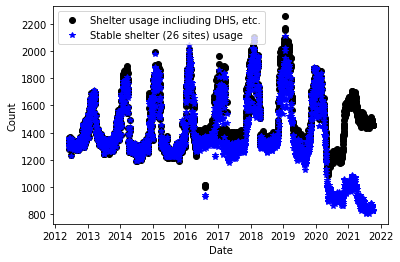

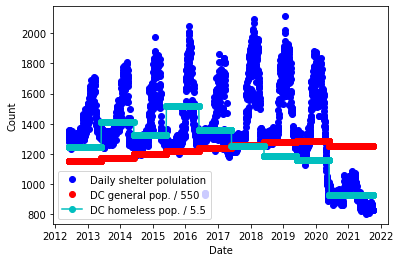

In [8]:
#Compare gendered and non-gendered data sets:
df_gen = df_gender
df_tot = df

df_gen['ScaleMetroBus'] = df_gen['MetroBus']*2000
df_gen['ScaleDCPop'] = df_gen['dc_pop']/550
df_gen['ScaleHomelessPop'] = df_gen['homeless_pop']/5.5
mask_gender = (df_gen['date'] <= datetime(2021, 10, 6)) & (df_gen['date'] >= datetime(2012, 6, 1))
df_sub_gen = df_gen[['date', 'ScaleMetroBus','ScaleDCPop', 'ScaleHomelessPop','Total']].loc[mask_gender]
df_sub_gen = df_sub_gen.dropna()
X_gen = df_sub_gen['date']
y_tot_gen = df_sub_gen['Total']
y_hom_gen = df_sub_gen['ScaleHomelessPop']
y_dc_gen = df_sub_gen['ScaleDCPop']
y_mb_gen = df_sub_gen['ScaleMetroBus']

df_tot['ScaleDCPop'] = df_tot['dc_pop']/550
df_tot['ScaleHomelessPop'] = df_tot['homeless_pop']/5.5
mask = (df_tot['date'] <= datetime(2021, 10, 6)) & (df_tot['date'] >= datetime(2012, 6, 1))
df_sub_nongen = df_tot[['date', 'ScaleDCPop', 'ScaleHomelessPop', 'Total']].loc[mask]
df_sub_nongen = df_sub_nongen.dropna()
X_nongen = df_sub_nongen['date']
y_tot_nongen = df_sub_nongen['Total']
y_hom_nongen = df_sub_nongen['ScaleHomelessPop']
y_dc_nongen = df_sub_nongen['ScaleDCPop']


plt.plot(X_gen, y_tot_gen, 'o', color='k', label='Shelter usage incliuding DHS, etc.');
plt.plot(X_nongen, y_tot_nongen, '*', color='b', label='Stable shelter (26 sites) usage');
plt.xlabel('Date')
plt.ylabel('Count');
plt.legend();
plt.show()

plt.plot(X_nongen, y_tot_nongen, 'o', color='b', label='Daily shelter polulation');
plt.plot(X_nongen, y_dc_nongen, 'o', color='r', label='DC general pop. / 550');
plt.plot(X_nongen, y_hom_nongen, 'o-', color='c', label='DC homeless pop. / 5.5');
plt.xlabel('Date')
plt.ylabel('Count');
plt.legend();
plt.show()


In [9]:
#Quick test to see if dayWeek is correlated with shelter bed usage...it is (with max usage in mid-week; min on weekends)

start_date = datetime(2019, 3, 1)
end_date = datetime(2020, 3, 1)
df_hold = df
mask_min = (df_hold['date'] > start_date) & (df_hold['date'] <= end_date)

df_min = df_hold[mask_min]
y = df_min['Total']

est = Pipeline([
    ('categorical', OneHotEncoder()),
    ('regressor', Ridge())
])

categorical_columns = ['dayWeek']
est.fit(df_min[categorical_columns], y)
est.predict(df_min[categorical_columns])
print(f'R^2 score using selected columns and transformers: {est.score(df_min[categorical_columns], y)}')

R^2 score using selected columns and transformers: 0.0005870519197872515


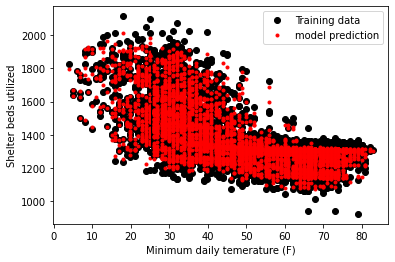

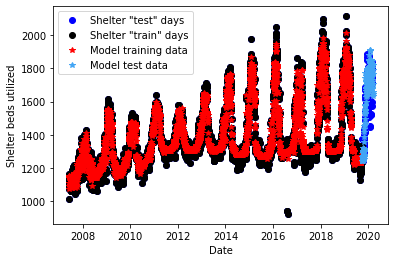

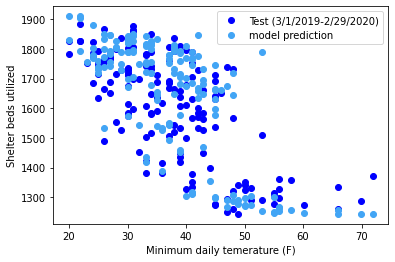

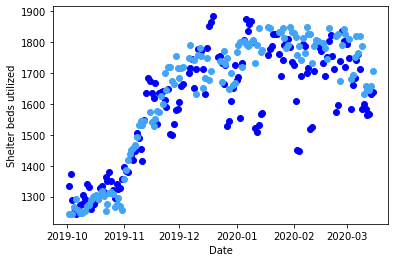

In [13]:
#Non-gendered data including dayWeek categorical data (df = original, ungendered data set):

test_start_date = datetime(2019, 10, 1) #inclusive datetime(2019, 3, 1)
test_end_date = datetime(2020, 3, 15) #not inclusive datetime(2020, 3, 1)
transition_temp = 26
df_selected = df
Pop_choice = 'Total'

#Metrobus for df_gender, 
all_columns = [Pop_choice,'date', 'prev_min_temp', 'dayWeek', 'year', 'MinTempF', 'dc_pop','homeless_pop', 'day_of_year','PrecipIn', 'SnowIn']
X_columns = ['prev_min_temp', 'dayWeek', 'MinTempF', 'dc_pop','homeless_pop', 'day_of_year','PrecipIn', 'SnowIn']
X_columns_low = ['prev_min_temp', 'dayWeek','MinTempF','dc_pop','homeless_pop', 'day_of_year','PrecipIn', 'SnowIn']
numerical_columns = ['prev_min_temp','MinTempF','dc_pop','homeless_pop', 'day_of_year','PrecipIn', 'SnowIn'] #This will be sent to poly
categorical_columns = ['dayWeek',]


train_start_date = datetime(2007, 6, 1)
train_end_date = datetime(2019, 10, 1)

#for plotting:
mask_full = (df_selected['date'] >= train_start_date) & (df_selected['date'] <= datetime(2020, 3, 1))
df_fulltimespan = df_selected.loc[mask_full]
df_fulltimespan = df_fulltimespan.dropna()
X_fulltime = df_fulltimespan['date']
y_fulltime = df_fulltimespan[Pop_choice]

#mask_train = (df['date'] > train_start_date) & (df['date'] <= train_end_date)
#df_trainB = df_trainB[all_columns]
mask_train = (df_selected['date'] > train_start_date) & (df_selected['date'] <= train_end_date)
df_trainB = df_selected.loc[mask_train]
df_trainB = df_trainB[all_columns]
df_trainB = df_trainB.dropna()
y_train = df_trainB[Pop_choice]
X_train = df_trainB[X_columns]
#mask_test = (df['date'] > test_start_date) & (df['date'] <= test_end_date)
#df_testB = df.loc[mask_test]
mask_test = (df_selected['date'] > test_start_date) & (df_selected['date'] <= test_end_date)
df_testB = df_selected.loc[mask_test]
df_testB = df_testB[all_columns]
df_testB = df_testB.dropna()
y_test = df_testB[Pop_choice]
X_test = df_testB[X_columns]


#two fitted ranges:
mask_train_range1 = (df_trainB['MinTempF'] < transition_temp)
mask_train_range2 = (df_trainB['MinTempF'] >= transition_temp) & (df_trainB['MinTempF'] <= 150)
df_train1 = df_trainB.loc[mask_train_range1]
y_train1 = df_train1[Pop_choice]
X_train1 = df_train1[X_columns_low] #could add more variables
X_traintime1 = df_train1['date']
df_train2 = df_trainB.loc[mask_train_range2]
y_train2 = df_train2[Pop_choice]
X_train2 = df_train2[X_columns] #could add more variables
X_traintime2 = df_train2['date']

mask_test_range1 = (df_testB['MinTempF'] < transition_temp)
mask_test_range2 = (df_testB['MinTempF'] >= transition_temp) & (df_testB['MinTempF'] <= 150)
df_test1 = df_testB.loc[mask_test_range1]
y_test1 = df_test1[Pop_choice]
X_test1 = df_test1[X_columns_low] #could add more variables
X_testtime1 = df_test1['date']
df_test2 = df_testB.loc[mask_test_range2]
y_test2 = df_test2[Pop_choice]
X_test2 = df_test2[X_columns] #could add more variables
X_testtime2 = df_test2['date']


preplow = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numeric', 'passthrough', numerical_columns),
    ('standard_scaler', StandardScaler(), X_columns_low),
    ('polynomial_trans', PolynomialFeatures(1), numerical_columns)
])
estlow = Pipeline([
    ('features', preplow),
    ('regressor', RandomForestRegressor(max_depth=8, random_state=42))
])
estlow.fit(X_train1,y_train1)
y_pred_train1 = estlow.predict(X_train1)
y_pred_test1 = estlow.predict(X_test1)
model_train = metrics.r2_score(y_train1, y_pred_train1)
#print('Training R^2 for training model range1:', model_train)
model_test = metrics.r2_score(y_test1, y_pred_test1)
#print('Training R^2 for testing model range1:', model_test)
print('')
    
prepmid = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numeric', 'passthrough', numerical_columns),
    ('standard_scaler', StandardScaler(), X_columns),
    ('polynomial_trans', PolynomialFeatures(3), numerical_columns)
])
estmid = Pipeline([
    ('features', prepmid),
    ('regressor', RandomForestRegressor(max_depth=8, random_state=42))
])
estmid.fit(X_train2,y_train2)
y_pred_train2 = estmid.predict(X_train2)
y_pred_test2 = estmid.predict(X_test2)


model_train = metrics.r2_score(y_train2, y_pred_train2)
#print('Training R^2 for training model range2:', model_train)
model_test = metrics.r2_score(y_test2, y_pred_test2)
#print('Training R^2 for testing model range2:', model_test)


plt.plot(X_train1['MinTempF'], y_train1, 'o', color='k', label="Training data");
plt.plot(X_train1['MinTempF'], y_pred_train1, '.', color='r', label='model prediction');
plt.plot(X_train2['MinTempF'], y_train2, 'o', color='k');
plt.plot(X_train2['MinTempF'], y_pred_train2, '.', color='r');
plt.xlabel('Minimum daily temerature (F)')
plt.ylabel('Shelter beds utilized');
plt.legend();
plt.show()


plt.plot(X_fulltime, y_fulltime, 'o', color='b', label='Shelter "test" days');
plt.plot(X_traintime1, y_train1, 'o', color='k', label='Shelter "train" days');
plt.plot(X_traintime2, y_train2, 'o', color='k');

plt.plot(X_traintime1, y_pred_train1, '*', color='r', label='Model training data');
plt.plot(X_traintime2, y_pred_train2, '*', color='r');

plt.plot(X_testtime1, y_pred_test1, '*',color='#42a5f5ff', label='Model test data' );
plt.plot(X_testtime2, y_pred_test2, '*', color='#42a5f5ff');
plt.xlabel('Date')
plt.ylabel('Shelter beds utilized');
plt.legend();
plt.show()


plt.plot(X_test1['MinTempF'], y_test1, 'o', color='b', label='Test (3/1/2019-2/29/2020)');
plt.plot(X_test1['MinTempF'], y_pred_test1, 'o',color='#42a5f5ff', label='model prediction');
plt.plot(X_test2['MinTempF'], y_test2, 'o', color='b');
plt.plot(X_test2['MinTempF'], y_pred_test2, 'o', color='#42a5f5ff');
#plt.plot(X_test3['MinTempF'], y_test3, 'o', color='b');
#plt.plot(X_test3['MinTempF'], y_pred_test3, color='#42a5f5ff');
plt.xlabel('Minimum daily temerature (F)')
plt.ylabel('Shelter beds utilized');
plt.legend();
plt.show()

plt.plot(X_testtime1, y_test1, 'o', color='b', label='Test (3/1/2019-2/29/2020)');
#plt.plot(X_testtime1, y_pred_test1, 'o',color='#42a5f5ff', label='model prediction');
plt.plot(X_testtime2, y_test2, 'o', color='b');
plt.plot(X_testtime2, y_pred_test2, 'o', color='#42a5f5ff');
#plt.plot(X_test3['MinTempF'], y_test3, 'o', color='b');
#plt.plot(X_test3['MinTempF'], y_pred_test3, color='#42a5f5ff');
plt.xlabel('Date')
plt.ylabel('Shelter beds utilized');
#plt.legend();
plt.show()



Training R^2 for training model range2: 0.9671519457766273
Training R^2 for testing model range2: 0.8699968380022458


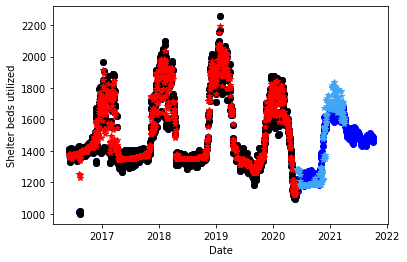

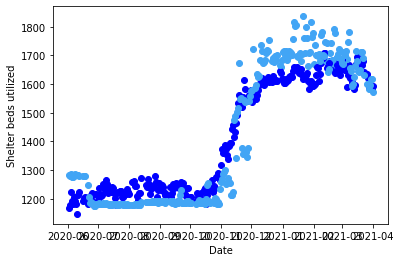

In [14]:
#Gendered data including dayWeek categorical data:

Pop_choice = 'Total' #choices are 'Total', 'Male', 'Female'

test_start_date = datetime(2020, 6, 1) #inclusive, 2020, 6, 1
test_end_date = datetime(2021, 4, 1) #not inclusive
transition_temp = 29

df_selected = df_gender
df_selected['Complete_Total'] = df_gender[Pop_choice] #Choices Total, Male, Female
#df_selected = df_gender #choices re df (non-gendered original), df_covid (non-gendered, longer time) or df_gender (df_gendered)

#MetroBus for df_gender, 
all_columns = [Pop_choice, 'Complete_Total','MetroBus', 'FreezingAtEntry', 'date', 'prev_min_temp', 'dayWeek', 'year', 'MinTempF', 'dc_pop', 'homeless_pop', 'day_of_year','PrecipIn', 'SnowIn']
X_columns = ['prev_min_temp', 'MetroBus', 'FreezingAtEntry', 'dayWeek', 'MinTempF', 'dc_pop', 'homeless_pop', 'day_of_year','PrecipIn', 'SnowIn']
X_columns_low = ['prev_min_temp', 'MetroBus', 'FreezingAtEntry', 'dayWeek','MinTempF', 'dc_pop', 'homeless_pop', 'day_of_year','PrecipIn', 'SnowIn']
numerical_columns = ['prev_min_temp','MetroBus', 'MinTempF', 'dc_pop', 'homeless_pop', 'day_of_year','PrecipIn', 'SnowIn'] #This will be sent to poly
categorical_columns = ['dayWeek','FreezingAtEntry']


train_start_date = datetime(2016, 6, 1) #2014, 6, 1
train_end_date = datetime(2020, 6, 1) #2020, 6, 1

#for plotting:
mask_full = (df_selected['date'] >= train_start_date) & (df_selected['date'] <= datetime(2021, 10, 1))
df_fulltimespan = df_selected.loc[mask_full]
df_fulltimespan = df_fulltimespan.dropna()
X_fulltime = df_fulltimespan['date']
y_fulltime = df_fulltimespan[Pop_choice]

#mask_train = (df['date'] > train_start_date) & (df['date'] <= train_end_date)
#df_trainB = df_trainB[all_columns]
mask_train = (df_selected['date'] > train_start_date) & (df_selected['date'] <= train_end_date)
df_trainB = df_selected.loc[mask_train]
df_trainB = df_trainB[all_columns]
df_trainB = df_trainB.dropna()
y_train = df_trainB[Pop_choice]
X_train = df_trainB[X_columns]
#mask_test = (df['date'] > test_start_date) & (df['date'] <= test_end_date)
#df_testB = df.loc[mask_test]
mask_test = (df_selected['date'] > test_start_date) & (df_selected['date'] <= test_end_date)
df_testB = df_selected.loc[mask_test]
df_testB = df_testB[all_columns]
df_testB = df_testB.dropna()
y_test = df_testB[Pop_choice]
X_test = df_testB[X_columns]

y_fulltime_true = df_fulltimespan['Complete_Total']
y_train_true = df_trainB['Complete_Total']
y_test_true = df_testB['Complete_Total']

#two fitted ranges:
mask_train_range1 = (df_trainB['MinTempF'] < transition_temp)
mask_train_range2 = (df_trainB['MinTempF'] >= transition_temp) & (df_trainB['MinTempF'] <= 150)
df_train1 = df_trainB.loc[mask_train_range1]
y_train1 = df_train1[Pop_choice]
y_train1_true = df_train1['Complete_Total']
X_train1 = df_train1[X_columns_low] #could add more variables
X_traintime1 = df_train1['date']
df_train2 = df_trainB.loc[mask_train_range2]
y_train2 = df_train2[Pop_choice]
y_train2_true = df_train2['Complete_Total']
X_train2 = df_train2[X_columns] #could add more variables
X_traintime2 = df_train2['date']

mask_test_range1 = (df_testB['MinTempF'] < transition_temp)
mask_test_range2 = (df_testB['MinTempF'] >= transition_temp) & (df_testB['MinTempF'] <= 150)
df_test1 = df_testB.loc[mask_test_range1]
y_test1 = df_test1[Pop_choice]
y_test1_true = df_test1['Complete_Total']
X_test1 = df_test1[X_columns_low] #could add more variables
X_testtime1 = df_test1['date']
df_test2 = df_testB.loc[mask_test_range2]
y_test2 = df_test2[Pop_choice]
y_test2_true = df_test2['Complete_Total']
X_test2 = df_test2[X_columns] #could add more variables
X_testtime2 = df_test2['date']


preplow = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numeric', 'passthrough', numerical_columns),
    ('standard_scaler', StandardScaler(), X_columns_low),
    ('polynomial_trans', PolynomialFeatures(1), numerical_columns)
])
estlow = Pipeline([
    ('features', preplow),
    #('standard_scaler', StandardScaler()),
    #('polynomial_trans', PolynomialFeatures(1)),
    #('LinearReg', LinearRegression())
    #('regressor', Ridge(alpha=10))
    ('regressor', RandomForestRegressor(max_depth=8, random_state=42))
])
estlow.fit(X_train1,y_train1)
y_pred_train1 = estlow.predict(X_train1)
y_pred_test1 = estlow.predict(X_test1)
model_train = metrics.r2_score(y_train1_true, y_pred_train1)
#print('Training R^2 for training model range1:', model_train)
model_test = metrics.r2_score(y_test1_true, y_pred_test1)
#print('Training R^2 for testing model range1:', model_test)
print('')
    
prepmid = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('numeric', 'passthrough', numerical_columns),
    ('standard_scaler', StandardScaler(), X_columns),
    ('polynomial_trans', PolynomialFeatures(3), numerical_columns)
])
estmid = Pipeline([
    ('features', prepmid),
    #('regressor', Ridge(alpha=20))
    ('regressor', RandomForestRegressor(max_depth=8, random_state=42))
    #('LinearReg', LinearRegression())
])
estmid.fit(X_train2,y_train2)
y_pred_train2 = estmid.predict(X_train2)
y_pred_test2 = estmid.predict(X_test2)
model_train = metrics.r2_score(y_train2_true, y_pred_train2)
print('Training R^2 for training model range2:', model_train)
model_test = metrics.r2_score(y_test2_true, y_pred_test2)
print('Training R^2 for testing model range2:', model_test)

plt.plot(X_fulltime, y_fulltime_true, 'o', color='b', label='Shelter "test" days');
plt.plot(X_traintime1, y_train1_true, 'o', color='k', label='Shelter "train" days');
plt.plot(X_traintime2, y_train2_true, 'o', color='k');

plt.plot(X_traintime1, y_pred_train1, '*', color='r', label='Model training data');
plt.plot(X_traintime2, y_pred_train2, '*', color='r');

plt.plot(X_testtime1, y_pred_test1, '*',color='#42a5f5ff', label='Model test data' );
plt.plot(X_testtime2, y_pred_test2, '*', color='#42a5f5ff');
plt.xlabel('Date')
plt.ylabel('Shelter beds utilized');
#plt.legend();
plt.show()

plt.plot(X_testtime1, y_test1_true, 'o', color='b', label='Test (6/1/2020-4/30/2021)');
plt.plot(X_testtime1, y_pred_test1, 'o',color='#42a5f5ff', label='model prediction');
plt.plot(X_testtime2, y_test2_true, 'o', color='b');
plt.plot(X_testtime2, y_pred_test2, 'o', color='#42a5f5ff');
#plt.plot(X_test3['MinTempF'], y_test3, 'o', color='b');
#plt.plot(X_test3['MinTempF'], y_pred_test3, color='#42a5f5ff');
plt.xlabel('Date')
plt.ylabel('Shelter beds utilized');
#plt.legend();
plt.show()




standard deviation of errors 34.47503270464288
standard deviation of errors 67.38601777795934
Train R2 0.9671519457766274
Test R2 0.8699968380022457


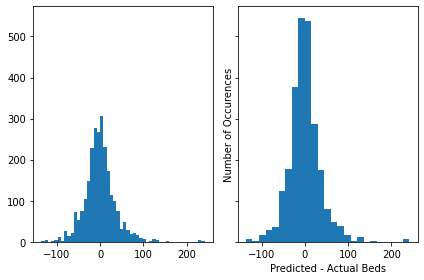

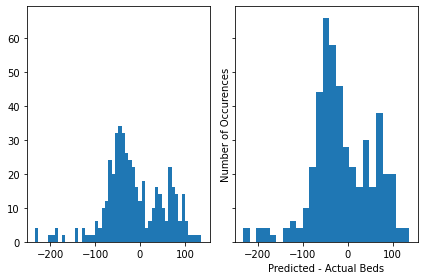

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def compute_R2(y_pred1, y_pred2, y_true1, y_true2):
    
    y_train = []
    y_ave = 0
    for item in y_true2:
        y_train.append(item)
        y_ave += item
    for item in y_true1:
        y_train.append(item)
        y_ave += item
    y_ave = y_ave/(1.0*len(y_train))

    y_pred = []
    for item in y_pred2:
        y_pred.append(item*1.0)
    for item in y_pred1:
        y_pred.append(item*1.0)

    diff_num = 0
    diff_denom= 0
    for i in range(0, len(y_train)):
        diff_num += (y_train[i] - y_pred[i])*(y_train[i] - y_pred[i])
        diff_denom += (y_train[i] - y_ave)*(y_train[i] - y_ave)

    R2= 1.0 - (diff_num / diff_denom)
    
    pred_diff = []
    std_diff = []
    for i in range(0,len(y_pred)):
        pred_diff.append(y_pred[i] - y_train[i])
        if y_pred[i] - y_train[i] < 200:
            std_diff.append(np.power(y_pred[i] - y_train[i],2))
        
    pred_bin = np.array(pred_diff)
    std = np.sqrt(sum(std_diff)/(1.0*len(y_pred)))
    print('standard deviation of errors', std)
    
    
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

    # We can set the number of bins with the `bins` kwarg
    axs[0].hist(pred_bin, bins=50)
    axs[1].hist(pred_bin, bins=25)
    plt.xlabel('Predicted - Actual Beds')
    plt.ylabel('Number of Occurences');

    return R2

R2_train = compute_R2(y_pred_train2, y_pred_train2, y_train2, y_train2)   
R2_test = compute_R2(y_pred_test2, y_pred_test2, y_test2, y_test2)  
    
print('Train R2', R2_train)
print('Test R2', R2_test)

In [16]:
import numpy as np


In [20]:
df_anon = pd.read_csv("homelessness_anonymized_data.csv")
df_anon = df_anon.dropna()
df_anon["count"] = pd.to_numeric(df_anon["count"])
df_anon['date'] = pd.to_datetime(df_anon['date'])
print(df_anon.head())

        date  count  cat_index
0 2005-10-01      1          0
1 2005-10-02      1          0
2 2005-10-03      1          0
3 2005-10-04      1          0
4 2005-10-05      1          0


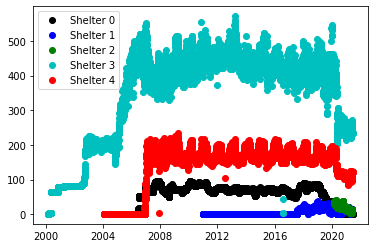

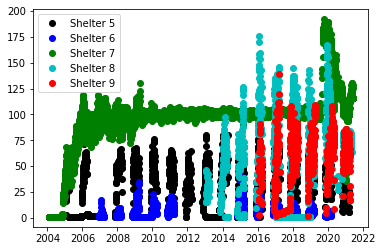

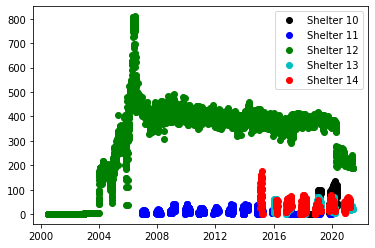

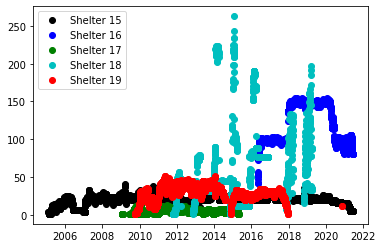

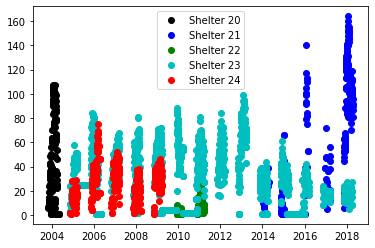

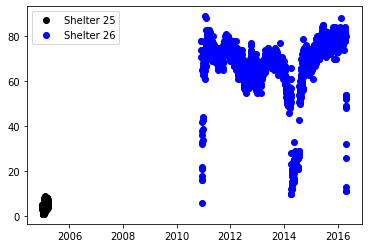

In [21]:
#Plotting shelter info -- different types (year-round, transient) and different periods of operation...

shelt_mask = (df_anon['cat_index'] == 0)
shelt0 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 1)
shelt1 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 2)
shelt2 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 3)
shelt3 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 4)
shelt4 = df_anon.loc[shelt_mask]

shelt_mask = (df_anon['cat_index'] == 5)
shelt5 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 6)
shelt6 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 7)
shelt7 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 8)
shelt8 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 9)
shelt9 = df_anon.loc[shelt_mask]

shelt_mask = (df_anon['cat_index'] == 10)
shelt10 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 11)
shelt11 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 12)
shelt12 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 13)
shelt13 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 14)
shelt14 = df_anon.loc[shelt_mask]

shelt_mask = (df_anon['cat_index'] == 15)
shelt15 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 16)
shelt16 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 17)
shelt17 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 18)
shelt18 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 19)
shelt19 = df_anon.loc[shelt_mask]

shelt_mask = (df_anon['cat_index'] == 20)
shelt20 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 21)
shelt21 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 22)
shelt22 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 23)
shelt23 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 24)
shelt24 = df_anon.loc[shelt_mask]

shelt_mask = (df_anon['cat_index'] == 25)
shelt25 = df_anon.loc[shelt_mask]
shelt_mask = (df_anon['cat_index'] == 26)
shelt26 = df_anon.loc[shelt_mask]

plt.plot(shelt0['date'], shelt0['count'], 'o', color='k', label='Shelter 0')
plt.plot(shelt1['date'], shelt1['count'], 'o', color='b', label='Shelter 1')
plt.plot(shelt2['date'], shelt2['count'], 'o', color='g', label='Shelter 2')
plt.plot(shelt3['date'], shelt3['count'], 'o', color='c', label='Shelter 3')
plt.plot(shelt4['date'], shelt4['count'], 'o', color='r', label='Shelter 4')
plt.legend();
plt.show()

plt.plot(shelt5['date'], shelt5['count'], 'o', color='k', label='Shelter 5')
plt.plot(shelt6['date'], shelt6['count'], 'o', color='b', label='Shelter 6')
plt.plot(shelt7['date'], shelt7['count'], 'o', color='g', label='Shelter 7')
plt.plot(shelt8['date'], shelt8['count'], 'o', color='c', label='Shelter 8')
plt.plot(shelt9['date'], shelt9['count'], 'o', color='r', label='Shelter 9')
plt.legend();
plt.show()

plt.plot(shelt10['date'], shelt10['count'], 'o', color='k', label='Shelter 10')
plt.plot(shelt11['date'], shelt11['count'], 'o', color='b', label='Shelter 11')
plt.plot(shelt12['date'], shelt12['count'], 'o', color='g', label='Shelter 12')
plt.plot(shelt13['date'], shelt13['count'], 'o', color='c', label='Shelter 13')
plt.plot(shelt14['date'], shelt14['count'], 'o', color='r', label='Shelter 14')
plt.legend();
plt.show()

plt.plot(shelt15['date'], shelt15['count'], 'o', color='k', label='Shelter 15')
plt.plot(shelt16['date'], shelt16['count'], 'o', color='b', label='Shelter 16')
plt.plot(shelt17['date'], shelt17['count'], 'o', color='g', label='Shelter 17')
plt.plot(shelt18['date'], shelt18['count'], 'o', color='c', label='Shelter 18')
plt.plot(shelt19['date'], shelt19['count'], 'o', color='r', label='Shelter 19')
plt.legend();
plt.show()

plt.plot(shelt20['date'], shelt20['count'], 'o', color='k', label='Shelter 20')
plt.plot(shelt21['date'], shelt21['count'], 'o', color='b', label='Shelter 21')
plt.plot(shelt22['date'], shelt22['count'], 'o', color='g', label='Shelter 22')
plt.plot(shelt23['date'], shelt23['count'], 'o', color='c', label='Shelter 23')
plt.plot(shelt24['date'], shelt24['count'], 'o', color='r', label='Shelter 24')
plt.legend();
plt.show()

plt.plot(shelt25['date'], shelt25['count'], 'o', color='k', label='Shelter 25')
plt.plot(shelt26['date'], shelt26['count'], 'o', color='b', label='Shelter 26')
plt.legend();
plt.show()

In [24]:
df_anon = pd.read_csv("homelessness_anonymized_data.csv")
#print(df_anon.head())

df_anon['date'] = pd.to_datetime(df_anon['date']) 
df_base = df_gender[['date', 'Total']]

shelt_mask = (df_anon['cat_index'] == 0)
df_holder = df_anon.loc[shelt_mask]
df_counts = df_holder[['date','count']]
df_counts = df_counts.fillna(0.0)
df_counts = df_counts.rename(columns={"count": 'RunningTotal'})
df_base = df_base.merge(df_counts, how='left', left_on='date', right_on='date')
df_base = df_base.fillna(0.0)
df_base['Shelt0'] = df_base['RunningTotal']
print(df_base.head())


for i in range(1, 27):
    name = 'Shelt' + str(i)
    name.strip()
    shelt_mask = (df_anon['cat_index'] == i)
    df_holder = df_anon.loc[shelt_mask]
    df_counts = df_holder[['date','count']]
    df_counts = df_counts.fillna(0.0)
    df_counts = df_counts.rename(columns={"count": name})
    df_base = df_base.merge(df_counts, how='left', left_on='date', right_on='date')
    df_base = df_base.fillna(0.0)
    df_base['RunningTotal'] = df_base['RunningTotal']  + df_base[name]

df_base = df_base.fillna(0.0)

df_base.head()




        date  Total  RunningTotal  Shelt0
0 2005-01-01  784.0           0.0     0.0
1 2005-01-02  833.0           0.0     0.0
2 2005-01-03  862.0           0.0     0.0
3 2005-01-04  878.0           0.0     0.0
4 2005-01-05  917.0           0.0     0.0


,date,Total,RunningTotal,Shelt0,Shelt1,Shelt2,Shelt3,Shelt4,Shelt5,Shelt6,...,Shelt17,Shelt18,Shelt19,Shelt20,Shelt21,Shelt22,Shelt23,Shelt24,Shelt25,Shelt26
0,2005-01-01,784.0,393.0,0.0,0.0,0.0,189.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2005-01-02,833.0,451.0,0.0,0.0,0.0,200.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2005-01-03,862.0,466.0,0.0,0.0,0.0,204.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,1.0,0.0
3,2005-01-04,878.0,469.0,0.0,0.0,0.0,197.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,1.0,0.0
4,2005-01-05,917.0,498.0,0.0,0.0,0.0,206.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,1.0,0.0


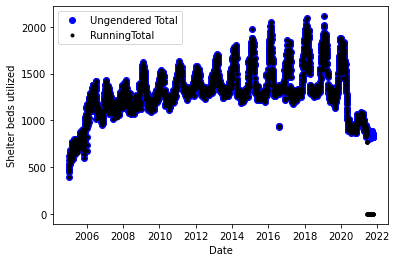

In [25]:
plt.plot(df['date'], df['Total'], 'o', color='b', label='Ungendered Total');
plt.plot(df_base['date'], df_base['RunningTotal'], '.', color='k', label='RunningTotal');
plt.xlabel('Date')
plt.ylabel('Shelter beds utilized');
plt.legend();
plt.show()